In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import torchvision
import os
from torchvision.transforms import v2
import glob
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import glob
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

## Plotter

In [2]:
class Plotter:

    def plot_training_val_b1(self, training_loss, val_loss, val_accuracy):
        epochs = range(1, len(training_loss) + 1)

        fig, ax1 = plt.subplots()
        ax1.plot(epochs, training_loss, 'b-', label='Training Loss')
        ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.set_title('Training and Validation Loss')

        plt.figure()
        plt.plot(epochs, val_accuracy, 'g-', label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Validation Accuracy')

        plt.show()

    def plot_test_b1(self, loss, metrics, confusion_data):
        # Print metrics
        print(f"Loss: {loss:.4f}")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1']:.4f}")

        # Plot confusion matrix
        cm = confusion_matrix(confusion_data['true_labels'], confusion_data['predictions'])
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

plotter = Plotter()

## Data Processing

In [3]:
class DataProcessorBaselineOne():
    def __init__(self, videos_root, map_classes=True):
        self.root = videos_root
        self.data_classes = self.concat_annotations()
        self.dataset = self.collect_video_data()

        self.map_classes = map_classes
        self.label_mapping = {'l-spike': 0, 'l_set': 1, 'r_set': 2, 'r-pass': 3, 'r_spike': 4, 'l-pass': 5, 'r_winpoint': 6, 'l_winpoint': 7}

        self.dataset_df = self.__prepare_df()


    def __prepare_df(self):
        df = pd.DataFrame(self.dataset)
        if self.map_classes:
            df['mapped_class'] = df['class'].map(self.label_mapping)
        return df

    def get_dataset(self):
        return self.dataset

    def get_dataset_df(self):
        return self.dataset_df

    def __process_annotations(self, annotations_file):
        data_dict = {}

        with open(annotations_file, 'r') as file:
            for line in file:
                parts = line.strip().split()

                if len(parts) > 1:  # Ensure there are at least 2 words
                    filename = parts[0]  # First word is the filename
                    action = parts[1]  # Second word is the action
                    data_dict[filename] = action

        return data_dict

    def concat_annotations(self):
        data_classes = {}
        for video_folder in sorted(os.listdir(self.root)):  # Iterate over videos
            video_path = os.path.join(self.root, video_folder)

            if not os.path.isdir(video_path):
                continue  # Skip files, process only directories

            for annotation_folder in sorted(os.listdir(video_path)):  # Iterate over clips
                annotation_path = os.path.join(video_path, annotation_folder)
                if not os.path.isdir(annotation_path):
                    if annotation_folder == 'annotations.txt':
                        data_classes = {**self.__process_annotations(annotation_path), **data_classes}

        return data_classes

    def collect_video_data(self):
        dataset = []  # List to store video data
        missing = 0
        for video_folder in sorted(os.listdir(self.root)):  # Iterate over videos
            video_path = os.path.join(self.root, video_folder)
            if not os.path.isdir(video_path):
                continue  # Skip files, process only directories

            for clip_folder in sorted(os.listdir(video_path)):  # Iterate over clips
                clip_path = os.path.join(video_path, clip_folder)
                if not os.path.isdir(clip_path):
                    continue

                frames = sorted(
                    [os.path.join(clip_path, f) for f in os.listdir(clip_path) if f.endswith(".jpg")]
                )
                if len(frames) == 41:  # Ensure expected number of frames
                    target_frame = frames[20]
                    frame_name = target_frame.split('/')[-1]
                    if frame_name in self.data_classes:
                        class_name = self.data_classes[frame_name]
                        dataset.append({
                            "video": video_folder,
                            "clip": clip_folder,
                            "frame": target_frame,
                            "class": class_name
                        })
                    else:
                        missing += 1

        print(f'missing {missing} frames')
        return dataset

Make sure you want to run this before running it

In [4]:
!rm -rf '/kaggle/working/'

rm: cannot remove '/kaggle/working/': Device or resource busy


In [5]:
base_path = '/kaggle/input/volleyball/volleyball_/videos/'
df = DataProcessorBaselineOne(base_path).get_dataset_df()

missing 3 frames


## Model

In [6]:
class ResnetEvolution(nn.Module):
    def __init__(self, hidden_layers=[]):
        super(ResnetEvolution, self).__init__()
        self.hidden_layers = hidden_layers
        self.model = self.__init_backbone(torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2))

    def __init_backbone(self, backbone):
        num_features = backbone.fc.in_features

        layers = []
        input_size = num_features  # Start with backbone output size
        for hidden_size in self.hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())  # Activation function
            input_size = hidden_size  # Update input for next layer

        layers.append(nn.Linear(input_size, 8))  # Final output layer

        backbone.fc = nn.Sequential(*layers)  # Output layer for binary classification

        return backbone

    def get_fc(self):
        return self.model.fc

    def forward(self, images):
        return self.model(images)

## Training Utils

In [7]:
class TrainingUtilities:
    @staticmethod
    def save_model(model, model_descriptor, save_folder, verbose=0):
        torch.save(model.state_dict(), save_folder + f"/{model_descriptor}b1_model.pth")
        if verbose > 0:
            print(f"Saved model to {save_folder}/b1_model.pth")

    @staticmethod
    def save_checkpoint(epoch, model_state_dict, optimizer_state_dict, scheduler_state_dict=None, save_folder='', verbose=0):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model_state_dict,
            'optimizer_state_dict': optimizer_state_dict,
            'scheduler_state_dict': scheduler_state_dict
        }
        torch.save(checkpoint, save_folder + f'/checkpoint-epoch{epoch}.pth')
        if verbose > 0:
            print(f'Saved checkpoint to {save_folder}/checkpoint-epoch{epoch}.pth')

    @staticmethod
    def load_checkpoint(model, optimizer, checkpoint_path, scheduled, verbose=0):
        checkpoint = torch.load(checkpoint_path)

        if verbose > 0:
            print(f"Loading checkpoint from {checkpoint_path}")

        epoch = checkpoint['epoch']
        model_state_dict = checkpoint['model_state_dict']
        optimizer_state_dict = checkpoint['optimizer_state_dict']
        scheduler_state_dict = checkpoint['scheduler_state_dict']
        model = model.load_state_dict(model_state_dict)
        if scheduled:
            optimizer.load_state_dict(optimizer_state_dict, scheduler_state_dict)
        else:
            optimizer = optimizer.load_state_dict(optimizer_state_dict)
        return epoch, model, optimizer

## Trainer

In [8]:
class b1_ModelTrainer:
    def __init__(self, model, optimizer, scheduled, criterion, epochs, dataloaders, device, save_folder,
                 is_continue=False, checkpoint=None):
        self.model = model
        self.optimizer = optimizer
        self.scheduled = scheduled
        self.criterion = criterion
        self.epochs = epochs
        self.dataloaders = dataloaders
        self.DEVICE = device
        self.save_folder = save_folder
        self.is_continue = is_continue
        self.checkpoint = checkpoint
        self.scaler = torch.amp.GradScaler()

    # verbose 1 : checkpoint,
    # verbose 3:  labels, preds
    # verbose 4: logits
    def train_model(self, verbose=0):
        model, optimizer, criterion, epochs, dataloaders, scaler = self.model, self.optimizer, self.criterion, self.epochs, self.dataloaders, self.scaler

        epoch = 0

        train_losses = []
        val_losses = []
        val_accuracies = []

        if self.is_continue:

            if verbose > 0:
                print(f"Continuing from checkpoint {self.checkpoint}")

            epoch, model, optimizer = self.__load_checkpoint(model, optimizer, self.checkpoint, verbose)

        for training_epoch in range(epoch, epochs):

            print(f"\nTraining epoch {training_epoch+1}")

            ## change model mode depending on the phase
            for phase in ['train', 'val']:
                dataloader = dataloaders[phase]
                epoch_loss = 0  # Track total loss for the epoch
                if phase == 'train':
                    if verbose > 0:
                        dataloader = tqdm(dataloader, desc=phase)
                    model.train()
                    for inputs, labels in dataloader:

                        inputs = inputs.to(self.DEVICE)
                        labels = labels.to(self.DEVICE)

                        if verbose > 3:
                            print(f"labels: {labels}")

                        # zero grads of he optim
                        optimizer.zero_grad()

                        # freeze the non-learnable weights
                        # self.__handle_transfer_learning(phase, training_epoch / epochs)

                        with torch.amp.autocast('cuda'):
                            # forward pass
                            logit = model(inputs)

                            if verbose > 3:
                                print(f"logit: {logit}")

                            loss = criterion(logit, labels)

                        scaler.scale(loss).backward()
                        optimizer.step(scaler)
                        scaler.update()

                        epoch_loss += loss.item()  # Accumulate loss

                    train_losses.append(epoch_loss / len(dataloader))
                    print(
                        f"Epoch {training_epoch + 1}/{epochs}, {phase} Loss: {epoch_loss / len(dataloader)}")  # Print loss
                else:
                    # skip evaluation if no suitable dataloader
                    if dataloaders[phase] is None:
                        continue
                    model.eval()
                    loss, acc = self.__eval_model(dataloader, verbose)
                    val_losses.append(loss)
                    val_accuracies.append(acc)
                    print(
                        f"Epoch {training_epoch + 1}/{epochs}, ({phase}) Loss: {loss} | Accuracy: {acc}")  # Print loss

            if self.scheduled:
                optimizer.scheduler_step()
                TrainingUtilities.save_checkpoint(training_epoch, model.state_dict(), optimizer.optimizer_state_dict(),
                                       optimizer.scheduler_state_dict(), self.save_folder, verbose)
            else:
                TrainingUtilities.save_checkpoint(training_epoch, model.state_dict(), optimizer.state_dict(),self.save_folder, verbose)

            if training_epoch % 10 == 0:
                TrainingUtilities.save_model(model, training_epoch, self.save_folder,verbose)

        TrainingUtilities.save_model(model, 'final_', self.save_folder, verbose)
        return train_losses, val_losses, val_accuracies

    def __handle_transfer_learning(self, phase, ratio_epochs, tl_coeff=0, verbose=0):
        if phase == "train":
            if self.__check_transfer_learning(ratio_epochs, tl_coeff):
                # Unfreeze all layers for fine-tuning
                for param in self.model.parameters():
                    param.requires_grad = True
            else:
                # Freeze the CNN part
                for param in self.model.parameters():
                    param.requires_grad = False
                # Unfreeze the classification layer
                for param in self.model.get_fc().parameters():
                    param.requires_grad = True
        elif phase == "val":
            for param in self.model.parameters():
                param.requires_grad = False

    def __check_transfer_learning(self, ratio_epochs, tl_coeff=0):
        return ratio_epochs >= tl_coeff

    def __eval_model(self, dataloader, verbose=0):
        model = self.model
        criterion = self.criterion
        model.eval()
        val_loss = 0
        correct_preds = 0
        total_preds = 0
        if verbose > 0:
            dataloader = tqdm(dataloader, desc="Validation")
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                for inputs, labels in dataloader:
                    inputs = inputs.to(self.DEVICE)
                    labels = labels.to(self.DEVICE)

                    if verbose > 2:
                        print(f"labels: {labels}")

                    # Forward pass
                    logits = model(inputs)

                    if verbose > 3:
                        print(f"logit: {logits}")

                    probs = F.softmax(logits, dim=1)  # Apply softmax to get probabilities

                    if verbose > 3:
                        print(f"probs: {probs}")

                    loss = criterion(logits, labels)
                    val_loss += loss.item()  # Accumulate loss

                    # Compute accuracy
                    predicted = torch.argmax(probs, dim=1)  # Get the class with the highest probability

                    if verbose > 2:
                        print(f"predicted: {predicted}")
                        print(f"true/false: {(predicted == labels)}")

                    correct_preds += (predicted == labels).sum().item()
                    total_preds += labels.size(0)

        # Calculate average loss and accuracy
        avg_loss = val_loss / len(dataloader)
        accuracy = correct_preds / total_preds
        return avg_loss, accuracy

## Dataset

In [9]:
class B1Dataset(Dataset):

    VIDEO_SPLITS = {
        'train': {1, 3, 6, 7, 10, 13, 15, 16, 18, 22, 23, 31, 32, 36, 38, 39, 40, 41, 42, 48, 50, 52, 53, 54},
        'val': {0, 2, 8, 12, 17, 19, 24, 26, 27, 28, 30, 33, 46, 49, 51},
        'test': {4, 5, 9, 11, 14, 20, 21, 25, 29, 34, 35, 37, 43, 44, 45, 47}
    }

    def __init__(self, data, split='train', transform=None):
        self.data = data
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.CenterCrop((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = transform

        if split in self.VIDEO_SPLITS:
            self.data = self.data[self.data['video'].astype(int).isin(self.VIDEO_SPLITS[split])]
        else:
            raise NameError(f'There is no such split: {split}, only {self.VIDEO_SPLITS}')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['frame']
        label = self.data.iloc[idx]['mapped_class']

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

## Loss

In [10]:
class WeightedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, dataset, device):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.dataset = dataset
        self.device = device
        weight = self.__compute_weights()
        self.loss = nn.CrossEntropyLoss(weight=weight)

    def __compute_weights(self):
        print('Computing weights...')
        label_counts = Counter([label.item() for _, label in self.dataset])
        total_samples = len(self.dataset)

        class_weights = [total_samples / label_counts[i] if i in label_counts else 0 for i in range(8)]

        weights = torch.tensor(class_weights, dtype=torch.float32).to(self.device)
        print('Weights computed.')
        return weights

    def forward(self, logit, target):
        return self.loss(logit, target)

## Optimizer

In [11]:
class AdamWScheduled():
    def __init__(self, model_params, lr, step_size, gamma):
        self.optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_params),  lr=lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size, gamma)

    def step(self, scaler):
        scaler.step(self.optimizer)

    def zero_grad(self):
        self.optimizer.zero_grad()

    def scheduler_step(self):
        self.scheduler.step()

    def optimizer_state_dict(self):
        return self.optimizer.state_dict()

    def scheduler_state_dict(self):
        return self.scheduler.state_dict()

    def load_state_dict(self, optimizer_state_dict, scheduler_state_dict):
        self.optimizer.load_state_dict(optimizer_state_dict)
        self.scheduler.load_state_dict(scheduler_state_dict)

## Dataloaders and Transforms

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
train_transform = transforms.Compose([
    transforms.Resize(256),            # Resize shorter side to 256     
    transforms.RandomResizedCrop(224),  # Randomly crop and resize to 224x224
    transforms.RandomRotation(degrees=5),                   # Randomly rotate images within ±5 degrees
    transforms.ToTensor(),                                   # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],        # Normalize using ImageNet mean and std values
                         std=[0.229, 0.224, 0.225]),         # (mean and std are the same used during ResNet pre-training)
])

train_dataset = B1Dataset(df, split='train', transform=train_transform)
val_dataset = B1Dataset(df, split='val')
test_dataset = B1Dataset(df, split='test')

In [14]:
batch_size = 150
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
dataloaders = {'train': train_loader, 'val': val_loader}

In [15]:
!mkdir '/kaggle/working/checkpoints/'

## Custom Criterion

In [16]:
criterion = WeightedCrossEntropyLoss(train_dataset, device)

Computing weights...
Weights computed.


## Model Training

In [17]:
model = ResnetEvolution(hidden_layers=[])
model = model.to(device)
optimizer = AdamWScheduled(model_params=model.parameters(), lr=0.001, step_size=2, gamma=0.6)

save_folder = '/kaggle/working/'
trainer = b1_ModelTrainer(model, optimizer,True, criterion, epochs=30, dataloaders=dataloaders, device=device, save_folder=save_folder)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


In [18]:
train_losses, val_losses, val_accuracies = trainer.train_model(verbose=0)


Training epoch 1
Epoch 1/30, train Loss: 1.9877105553944905
Epoch 1/30, (val) Loss: 8.56847752465142 | Accuracy: 0.1715137956748695

Training epoch 2
Epoch 2/30, train Loss: 1.628822127978007
Epoch 2/30, (val) Loss: 2.129059765073988 | Accuracy: 0.2960477255779269

Training epoch 3
Epoch 3/30, train Loss: 1.4820833524068198
Epoch 3/30, (val) Loss: 1.5553545819388495 | Accuracy: 0.44668158090976884

Training epoch 4
Epoch 4/30, train Loss: 1.3604434728622437
Epoch 4/30, (val) Loss: 1.637855503294203 | Accuracy: 0.39671886651752425

Training epoch 5
Epoch 5/30, train Loss: 1.3093400955200196
Epoch 5/30, (val) Loss: 1.489213850763109 | Accuracy: 0.4891871737509321

Training epoch 6
Epoch 6/30, train Loss: 1.2121087153752645
Epoch 6/30, (val) Loss: 1.4260320001178317 | Accuracy: 0.5093214019388516

Training epoch 7
Epoch 7/30, train Loss: 1.136126987139384
Epoch 7/30, (val) Loss: 1.3395677076445685 | Accuracy: 0.5689783743475019

Training epoch 8
Epoch 8/30, train Loss: 1.1092886765797934

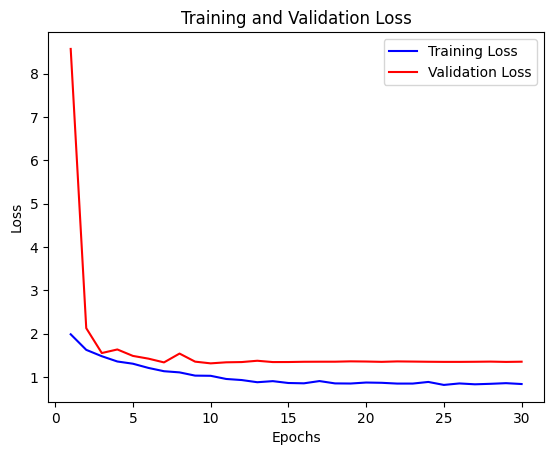

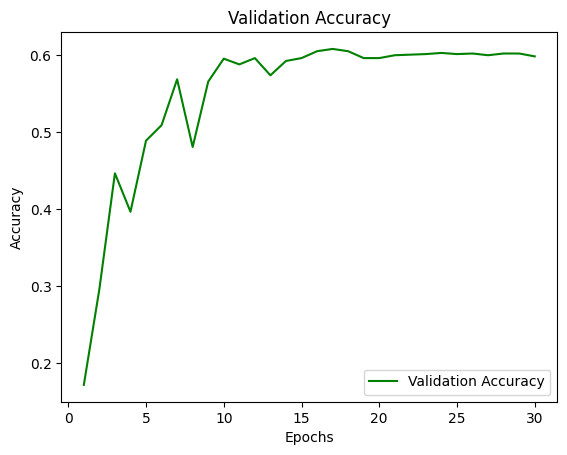

In [19]:
plotter.plot_training_val_b1(train_losses, val_losses, val_accuracies)

## Model Evaluation

In [20]:
class b1_ModelTester():
    def __init__(self, model, model_path, criterion, dataloader, device):
        self.model = model
        model_state_dict = torch.load(model_path, map_location=device)
        self.model.load_state_dict(model_state_dict)
        self.criterion = criterion
        self.dataloader = dataloader
        self.DEVICE = device

    def evaluate(self, verbose=0):
        dataloader = self.dataloader
        model = self.model
        criterion = self.criterion
        model.eval()

        # Initialize metrics tracking
        val_loss = 0
        all_labels = []
        all_predictions = []
        all_probabilities = []

        if verbose > 0:
            dataloader = tqdm(dataloader, desc="Testing")

        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                for inputs, labels in dataloader:
                    inputs = inputs.to(self.DEVICE)
                    labels = labels.to(self.DEVICE)

                    if verbose > 2:
                        print(f"labels: {labels}")

                    # Forward pass
                    logits = model(inputs)
                    probs = F.softmax(logits, dim=1)

                    if verbose > 3:
                        print(f"logits: {logits}")
                        print(f"probs: {probs}")

                    # Calculate loss
                    loss = criterion(logits, labels)
                    val_loss += loss.item()

                    # Get predictions
                    predicted = torch.argmax(probs, dim=1)

                    if verbose > 2:
                        print(f"predicted: {predicted}")
                        print(f"true/false: {(predicted == labels)}")

                    # Store predictions and labels for later metric calculation
                    all_labels.extend(labels.cpu().numpy())
                    all_predictions.extend(predicted.cpu().numpy())
                    all_probabilities.extend(probs.cpu().numpy())

        # Calculate average loss
        avg_loss = val_loss / len(dataloader)

        # Convert lists to numpy arrays for easier manipulation
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)
        all_probabilities = np.array(all_probabilities)

        # Calculate metrics for each class
        num_classes = all_probabilities.shape[1]
        metrics_dict = {
            'accuracy': accuracy_score(all_labels, all_predictions),
            'precision': precision_score(all_labels, all_predictions, average='macro', zero_division=0),
            'recall': recall_score(all_labels, all_predictions, average='macro', zero_division=0),
            'f1': f1_score(all_labels, all_predictions, average='macro', zero_division=0),
            'per_class': {
                'precision': precision_score(all_labels, all_predictions, average=None, zero_division=0),
                'recall': recall_score(all_labels, all_predictions, average=None, zero_division=0),
                'f1': f1_score(all_labels, all_predictions, average=None, zero_division=0)
            }
        }

        # Prepare confusion matrix data
        confusion_data = {
            'true_labels': all_labels,
            'predictions': all_predictions,
            'probabilities': all_probabilities,
            'num_classes': num_classes
        }

        return avg_loss, metrics_dict, confusion_data

In [21]:
model = ResnetEvolution(hidden_layers=[]).to(device)
model_path = '/kaggle/input/b1_model/pytorch/b1_model/1/notebooks/b1-model-kaggle-trainer-super-resnet/model/b1_model.pth'
tester = b1_ModelTester(model, model_path, criterion, test_loader, device)

<ipython-input-20-1442f6c07dee>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_path, map_location=device)


In [22]:
loss, metrics, confusion_data = tester.evaluate(verbose=1)

Testing: 100%|██████████| 9/9 [00:12<00:00,  1.38s/it]


Loss: 1.5926
Accuracy: 0.6432
Precision: 0.6493
Recall: 0.6524
F1 Score: 0.6484


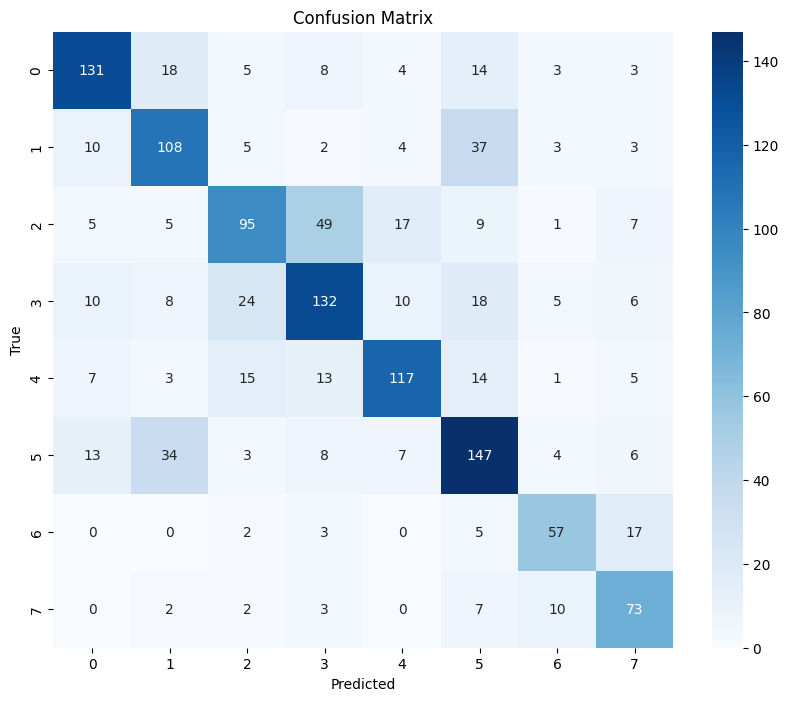

In [23]:
plotter.plot_test_b1(loss, metrics, confusion_data)